In [1]:
import random
from PIL import Image, ImageOps
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50
from torch.utils.data import DataLoader, Subset, random_split
from sklearn.model_selection import KFold
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Seed for reproducibility
SEED = 309
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


Using device: cuda


In [2]:
import os
import numpy as np
import cv2
from PIL import Image, ImageOps

# Dataset paths
dataset_path = 'train_data'
output_path = 'processed_data'
classes = ['tomato', 'cherry', 'strawberry']
target_size = (128, 128)

# Ensure output directory exists
os.makedirs(output_path, exist_ok=True)
for cls in classes:
    os.makedirs(os.path.join(output_path, cls), exist_ok=True)

# Manually selected invalid images below the threshold for each class
invalid_images_below_threshold = {
    'tomato': 
        ['tomato_0091.jpg', 'tomato_0092.jpg', 'tomato_0113.jpg', 'tomato_0147.jpg', 'tomato_0154.jpg', 'tomato_0155.jpg', 'tomato_0160.jpg', 'tomato_0265.jpg', 'tomato_0282.jpg', 'tomato_0347.jpg', 'tomato_0359.jpg', 'tomato_0411.jpg', 'tomato_0412.jpg', 'tomato_0413.jpg', 'tomato_0463.jpg', 'tomato_0496.jpg', 'tomato_0516.jpg', 'tomato_0562.jpg', 'tomato_0580.jpg', 'tomato_0646.jpg', 'tomato_1158.jpg', 'tomato_1260.jpg', 'tomato_1264.jpg', 'tomato_1281.jpg', 'tomato_1284.jpg', 'tomato_1285.jpg', 'tomato_1301.jpg', 'tomato_1448.jpg', 'tomato_1502.jpg', 'tomato_1520.jpg', 'tomato_1535.jpg', 'tomato_1536.jpg', 'tomato_1617.jpg', 'tomato_1670.jpg', 'tomato_1687.jpg', 'tomato_1746.jpg', 'tomato_1831.jpg', 'tomato_1957.jpg', 'tomato_1959.jpg', 'tomato_1960.jpg'],
    
    'cherry': 
        ['cherry_0113.jpg', 'cherry_0187.jpg', 'cherry_0310.jpg', 'cherry_0318.jpg', 'cherry_0368.jpg', 'cherry_0768.jpg', 'cherry_0843.jpg', 'cherry_1017.jpg', 'cherry_1057.jpg', 'cherry_1297.jpg', 'cherry_1315.jpg', 'cherry_1357.jpg', 'cherry_1384.jpg', 'cherry_1424.jpg', 'cherry_1499.jpg', 'cherry_1556.jpg', 'cherry_1691.jpg', 'cherry_1760.jpg', 'cherry_1801.jpg', 'cherry_2012.jpg', 'cherry_2049.jpg', 'cherry_2182.jpg', 'cherry_2184.jpg', 'cherry_2190.jpg', 'cherry_2265.jpg', 'cherry_2299.jpg', 'cherry_2348.jpg'],
    
    'strawberry': 
        ['strawberry_0004.jpg', 'strawberry_0028.jpg', 'strawberry_0035.jpg', 'strawberry_0045.jpg', 'strawberry_0046.jpg', 'strawberry_0083.jpg', 'strawberry_0084.jpg', 'strawberry_0087.jpg', 'strawberry_0092.jpg', 'strawberry_0146.jpg', 'strawberry_0178.jpg', 'strawberry_0179.jpg', 'strawberry_0181.jpg', 'strawberry_0190.jpg', 'strawberry_0239.jpg', 'strawberry_0246.jpg', 'strawberry_0261.jpg', 'strawberry_0296.jpg', 'strawberry_0350.jpg', 'strawberry_0385.jpg', 'strawberry_0388.jpg', 'strawberry_0389.jpg', 'strawberry_0390.jpg', 'strawberry_0491.jpg', 'strawberry_0497.jpg', 'strawberry_0504.jpg', 'strawberry_0571.jpg', 'strawberry_0592.jpg', 'strawberry_0627.jpg', 'strawberry_0657.jpg', 'strawberry_0662.jpg', 'strawberry_0754.jpg', 'strawberry_1023.jpg', 'strawberry_1052.jpg', 'strawberry_1055.jpg', 'strawberry_1089.jpg', 'strawberry_1154.jpg', 'strawberry_1161.jpg', 'strawberry_1189.jpg', 'strawberry_1192.jpg', 'strawberry_1225.jpg', 'strawberry_1298.jpg', 'strawberry_1323.jpg', 'strawberry_1342.jpg', 'strawberry_1350.jpg', 'strawberry_1393.jpg', 'strawberry_1405.jpg', 'strawberry_1478.jpg', 'strawberry_1488.jpg', 'strawberry_1513.jpg', 'strawberry_1541.jpg', 'strawberry_1547.jpg', 'strawberry_1553.jpg', 'strawberry_1560.jpg', 'strawberry_1606.jpg', 'strawberry_1624.jpg', 'strawberry_1642.jpg', 'strawberry_1660.jpg', 'strawberry_1665.jpg', 'strawberry_1715.jpg', 'strawberry_1733.jpg', 'strawberry_1738.jpg', 'strawberry_1819.jpg', 'strawberry_1820.jpg', 'strawberry_1839.jpg', 'strawberry_1843.jpg', 'strawberry_1853.jpg', 'strawberry_1876.jpg', 'strawberry_1895.jpg', 'strawberry_1941.jpg', 'strawberry_1993.jpg', 'strawberry_2108.jpg', 'strawberry_2146.jpg']
}

# Blurry image detection function
def is_blurry(image):
    gray_image = np.array(image.convert('L'))
    laplacian_var = cv2.Laplacian(gray_image, cv2.CV_64F).var()
    return laplacian_var > 2000  # Threshold for blurriness

# Tracking counters
count = 0
skipped_images = {cls: 0 for cls in classes}
removed_images = {cls: 0 for cls in classes}

# Preprocess images
for fruit_class in classes:
    folder_path = os.path.join(dataset_path, fruit_class)
    output_folder_path = os.path.join(output_path, fruit_class)
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)

        # Remove manually selected invalid images below the threshold if they exist
        if image_file in invalid_images_below_threshold[fruit_class]:
            print(f"Removed invalid image below threshold: {image_path}")
            removed_images[fruit_class] += 1
            continue

        # Open the image
        image = Image.open(image_path)

        # Check for blur
        if is_blurry(image):
            print(f"Skipping blurry image: {image_path}")
            count += 1
            skipped_images[fruit_class] += 1
            continue
        
        # Resize and save preprocessed image
        image = ImageOps.fit(image, target_size, Image.LANCZOS)
        processed_image_path = os.path.join(output_folder_path, image_file)
        image.save(processed_image_path)

print("Preprocessing completed. Processed images are saved in the 'processed_data' folder.")
print(f"Skipped {count} blurry images.")
for fruit_class, count in skipped_images.items():
    print(f"Skipped {count} images due to blurriness: {fruit_class}")
for fruit_class, count in removed_images.items():
    print(f"Removed {count} manually invalid images below threshold: {fruit_class}")


Skipping blurry image: train_data\tomato\tomato_0055.jpg
Removed invalid image below threshold: train_data\tomato\tomato_0091.jpg
Removed invalid image below threshold: train_data\tomato\tomato_0092.jpg
Removed invalid image below threshold: train_data\tomato\tomato_0113.jpg
Skipping blurry image: train_data\tomato\tomato_0136.jpg
Removed invalid image below threshold: train_data\tomato\tomato_0147.jpg
Skipping blurry image: train_data\tomato\tomato_0153.jpg
Removed invalid image below threshold: train_data\tomato\tomato_0154.jpg
Removed invalid image below threshold: train_data\tomato\tomato_0155.jpg
Skipping blurry image: train_data\tomato\tomato_0156.jpg
Skipping blurry image: train_data\tomato\tomato_0157.jpg
Skipping blurry image: train_data\tomato\tomato_0158.jpg
Removed invalid image below threshold: train_data\tomato\tomato_0160.jpg
Skipping blurry image: train_data\tomato\tomato_0228.jpg
Skipping blurry image: train_data\tomato\tomato_0241.jpg
Skipping blurry image: train_data

In [3]:
# Define transformations
transform_train = transforms.Compose([
    transforms.Resize((128,128)),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomRotation(degrees=(-30, 30)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [4]:
# Define data directories
data_root = './train_data/'
preprocessed_data_root = './processed_data/'

# Load datasets with transformations
train_dataset = ImageFolder(root=preprocessed_data_root, transform=transform_train)
# test_dataset = ImageFolder(root=preprocessed_data_root, transform=transform_test)

# Split datasets into training and test sets
batch_size = 64
train_size = int(0.8 * len(train_dataset))
test_size = len(train_dataset) - train_size
train_dataset, test_dataset = random_split(train_dataset, [train_size, test_size])

# Load data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Baseline Model

In [5]:
# MLP Model for baseline comparison
class MLPModel(nn.Module):
    def __init__(self, input_size=128*128*3, hidden_size=100, num_classes=3):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the image
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialize MLP model, criterion, and optimizer
mlp_model = MLPModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)


In [6]:
def train_mlp_model(data_loader):
    mlp_model.train()
    num_epochs = 10
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = mlp_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(data_loader):.4f}")

# Train MLP model
train_mlp_model(train_loader)


Epoch [1/10], Loss: 2.6755
Epoch [2/10], Loss: 1.4504
Epoch [3/10], Loss: 1.1586
Epoch [4/10], Loss: 1.0746
Epoch [5/10], Loss: 1.0892
Epoch [6/10], Loss: 0.9451
Epoch [7/10], Loss: 0.9731
Epoch [8/10], Loss: 0.8342
Epoch [9/10], Loss: 0.8016
Epoch [10/10], Loss: 0.6738


In [7]:
def evaluate_mlp_model(model, train_loader, test_loader):
    model.eval()
    
    def evaluate(data_loader):
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in data_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        return accuracy
    
    train_accuracy = evaluate(train_loader)
    test_accuracy = evaluate(test_loader)
    
    print(f'MLP Model Train Accuracy: {train_accuracy:.2f}%')
    print(f'MLP Model Test Accuracy: {test_accuracy:.2f}%')
    
    return train_accuracy, test_accuracy

# Evaluate MLP Model
evaluate_mlp_model(mlp_model, train_loader, test_loader)

MLP Model Train Accuracy: 75.84%
MLP Model Test Accuracy: 51.74%


(75.84033613445378, 51.74069627851141)

# Convolutional Neural Network

In [8]:
# CNN Model with dynamic flattened layer size
class CNN(nn.Module):
    def __init__(self, layers):
        super(CNN, self).__init__()
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

# Build CNN model with variable convolutional layers
def build_cnn(num_conv_layers):
    layers = []
    in_channels = 3
    for i in range(num_conv_layers):
        layers.extend([
            nn.Conv2d(in_channels, 6 * (2 ** i), kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        ])
        in_channels = 6 * (2 ** i)

    # Calculate the flattened dimension after convolutional layers
    dummy_input = torch.randn(1, 3, 128, 128).to(device)  # Match input image size here
    with torch.no_grad():
        # Move layers to device (GPU) for dummy calculation
        dummy_output = nn.Sequential(*layers).to(device)(dummy_input)
    flattened_size = dummy_output.view(-1).shape[0]

    # Add fully connected layers
    layers.extend([
        nn.Flatten(),
        nn.Linear(flattened_size, 128),
        nn.ReLU(),
        nn.Linear(128, 3)  # Adjust for number of classes
    ])
    
    return CNN(layers).to(device)

# Define train_and_evaluate function
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs=5):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    # Evaluation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")
    return accuracy

# Initialize models with 1, 2, and 3 convolutional layers
models = {
    "1 Conv Layer": build_cnn(1),
    "2 Conv Layers": build_cnn(2),
    "3 Conv Layers": build_cnn(3)
}

In [9]:
# %%
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")
    
    # Evaluation on test set
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Accuracy on test set: {accuracy:.2f}%')
    return accuracy

# Dictionary to store model accuracies
accuracies = {}


In [10]:

# Define cross-validation function
def cross_validate_model(model, train_dataset, folds=3):
    kf = KFold(n_splits=folds, shuffle=True)
    accuracies = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
        train_subset = Subset(train_dataset, train_idx)
        val_subset = Subset(train_dataset, val_idx)
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        valloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        
        # Optimizer and criterion
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()
        
        # Train and evaluate
        accuracy = train_and_evaluate(model, train_loader, valloader, criterion, optimizer)
        accuracies.append(accuracy)
    
    avg_accuracy = np.mean(accuracies)
    print(f"Average cross-validated accuracy: {avg_accuracy:.2f}%")
    return avg_accuracy

# Test different optimizers
def test_optimizers(model, optimizers, train_loader, test_loader, epochs=5):
    results = {}
    for opt_name, opt_fn in optimizers.items():
        model_copy = build_cnn(2)  # Build a new model instance
        optimizer = opt_fn(model_copy.parameters())
        criterion = nn.CrossEntropyLoss()
        print(f"\nTesting optimizer: {opt_name}")
        accuracy = train_and_evaluate(model_copy, train_loader, test_loader, criterion, optimizer, epochs)
        results[opt_name] = accuracy
    return results

# Optimizer configurations
optimizers = {
    "SGD": lambda params: optim.SGD(params, lr=0.001, momentum=0.9),
    "Adam": lambda params: optim.Adam(params, lr=0.001),
    "RMSProp": lambda params: optim.RMSprop(params, lr=0.001)
}


In [11]:
# Initialize accuracies dictionary to store model accuracies
accuracies = {}

# Training and recording each model's accuracy
for model_name, model in models.items():
    print(f"\nTraining model: {model_name}")
    accuracy = train_and_evaluate(model, train_loader, test_loader, nn.CrossEntropyLoss(), optim.Adam(model.parameters()))
    accuracies[model_name] = accuracy

# Cross-validation
for model_name, model in models.items():
    print(f"\nCross-validating model: {model_name}")
    avg_accuracy = cross_validate_model(model, train_dataset)
    accuracies[f"{model_name} (CV)"] = avg_accuracy

# Test different optimizers
optimizer_results = test_optimizers(build_cnn(2), optimizers, train_loader, test_loader)
accuracies.update(optimizer_results)

# Display collected accuracies
print("\nModel Accuracies:")
for model, acc in accuracies.items():
    print(f"{model}: {acc:.2f}%")


Training model: 1 Conv Layer
Epoch [1/5], Loss: 1.1036
Epoch [2/5], Loss: 0.9634
Epoch [3/5], Loss: 0.9243
Epoch [4/5], Loss: 0.8669
Epoch [5/5], Loss: 0.8142
Accuracy on test set: 48.74%

Training model: 2 Conv Layers
Epoch [1/5], Loss: 1.0785
Epoch [2/5], Loss: 0.9474
Epoch [3/5], Loss: 0.8776
Epoch [4/5], Loss: 0.8209
Epoch [5/5], Loss: 0.7206
Accuracy on test set: 57.98%

Training model: 3 Conv Layers
Epoch [1/5], Loss: 1.0494
Epoch [2/5], Loss: 0.9635
Epoch [3/5], Loss: 0.9425
Epoch [4/5], Loss: 0.9033
Epoch [5/5], Loss: 0.8941
Accuracy on test set: 51.86%

Cross-validating model: 1 Conv Layer
Epoch [1/5], Loss: 0.7147
Epoch [2/5], Loss: 0.6043
Epoch [3/5], Loss: 0.5129
Epoch [4/5], Loss: 0.4125
Epoch [5/5], Loss: 0.3363
Accuracy on test set: 68.86%
Epoch [1/5], Loss: 0.5673
Epoch [2/5], Loss: 0.4224
Epoch [3/5], Loss: 0.3403
Epoch [4/5], Loss: 0.2590
Epoch [5/5], Loss: 0.1998
Accuracy on test set: 87.76%
Epoch [1/5], Loss: 0.3279
Epoch [2/5], Loss: 0.1985
Epoch [3/5], Loss: 0.15

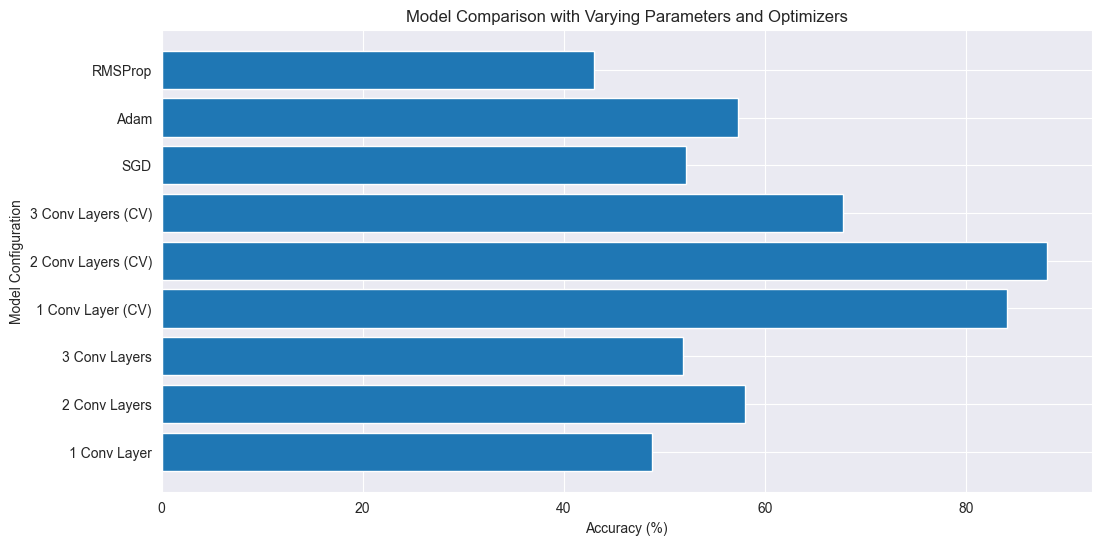

In [12]:
# %%
# Plotting results
plt.figure(figsize=(12, 6))
plt.barh(list(accuracies.keys()), list(accuracies.values()))
plt.xlabel("Accuracy (%)")
plt.ylabel("Model Configuration")
plt.title("Model Comparison with Varying Parameters and Optimizers")
plt.show()


In [13]:
# %%
model_resnet = resnet50(weights="IMAGENET1K_V2")
for param in model_resnet.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify the last layer to output 3 classes
num_features = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_features, 3)
model_resnet = model_resnet.to(device)

# Define optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=0.001)

# Train and evaluate transfer learning model
print("\nTraining Transfer Learning Model (ResNet-50):")
transfer_learning_accuracy = train_and_evaluate(model_resnet, train_loader, test_loader, criterion, optimizer, epochs=10)
accuracies["Transfer Learning (ResNet-50)"] = transfer_learning_accuracy


Training Transfer Learning Model (ResNet-50):
Epoch [1/10], Loss: 0.7870
Epoch [2/10], Loss: 0.5156
Epoch [3/10], Loss: 0.4306
Epoch [4/10], Loss: 0.3850
Epoch [5/10], Loss: 0.3543
Epoch [6/10], Loss: 0.3295
Epoch [7/10], Loss: 0.2908
Epoch [8/10], Loss: 0.2800
Epoch [9/10], Loss: 0.2594
Epoch [10/10], Loss: 0.2556
Accuracy on test set: 87.64%



Training Transfer Learning Model (ResNet-50):
Epoch [1/10], Loss: 0.2654, Train Accuracy: 92.80%, Test Accuracy: 87.76%
Epoch [2/10], Loss: 0.2349, Train Accuracy: 93.73%, Test Accuracy: 87.27%
Epoch [3/10], Loss: 0.2205, Train Accuracy: 93.46%, Test Accuracy: 87.64%
Epoch [4/10], Loss: 0.2075, Train Accuracy: 93.58%, Test Accuracy: 88.12%
Epoch [5/10], Loss: 0.1938, Train Accuracy: 94.99%, Test Accuracy: 88.12%
Epoch [6/10], Loss: 0.2027, Train Accuracy: 94.99%, Test Accuracy: 87.39%
Epoch [7/10], Loss: 0.1921, Train Accuracy: 94.63%, Test Accuracy: 87.27%
Epoch [8/10], Loss: 0.1920, Train Accuracy: 94.54%, Test Accuracy: 87.76%
Epoch [9/10], Loss: 0.1744, Train Accuracy: 95.20%, Test Accuracy: 87.15%
Epoch [10/10], Loss: 0.1671, Train Accuracy: 95.83%, Test Accuracy: 87.76%


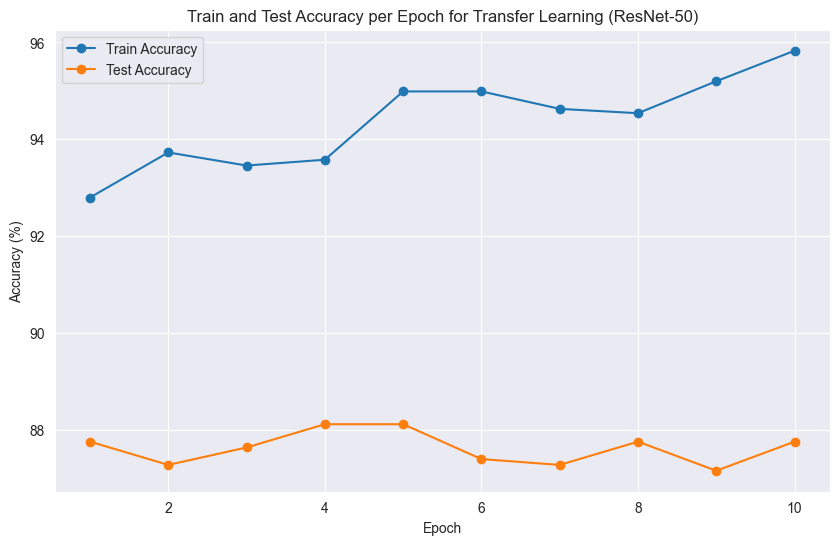

In [14]:
import matplotlib.pyplot as plt

# Update train_and_evaluate to track both training and test accuracy per epoch
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    model.to(device)
    train_accuracies = []  # Store training accuracy for each epoch
    test_accuracies = []   # Store test accuracy for each epoch
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        # Calculate and store training accuracy
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        
        # Calculate test accuracy
        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        
        # Calculate and store test accuracy
        test_accuracy = 100 * correct_test / total_test
        test_accuracies.append(test_accuracy)
        
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")
    
    return train_accuracies, test_accuracies

# Initialize and train the model while tracking accuracies
print("\nTraining Transfer Learning Model (ResNet-50):")
train_accuracies, test_accuracies = train_and_evaluate(model_resnet, train_loader, test_loader, criterion, optimizer, epochs=10)

# Plotting train and test accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), train_accuracies, marker='o', label='Train Accuracy')
plt.plot(range(1, 11), test_accuracies, marker='o', label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train and Test Accuracy per Epoch for Transfer Learning (ResNet-50)")
plt.legend()
plt.show()



Training Transfer Learning Model (ResNet-50):
Epoch [1/10], Loss: 0.1694, Train Accuracy: 95.74%, Test Accuracy: 87.64%
Epoch [2/10], Loss: 0.1671, Train Accuracy: 95.80%, Test Accuracy: 87.52%
Epoch [3/10], Loss: 0.1595, Train Accuracy: 95.77%, Test Accuracy: 88.36%
Epoch [4/10], Loss: 0.1702, Train Accuracy: 95.86%, Test Accuracy: 87.15%
Epoch [5/10], Loss: 0.1502, Train Accuracy: 96.22%, Test Accuracy: 87.52%
Epoch [6/10], Loss: 0.1497, Train Accuracy: 96.40%, Test Accuracy: 87.03%
Epoch [7/10], Loss: 0.1442, Train Accuracy: 96.49%, Test Accuracy: 88.00%
Epoch [8/10], Loss: 0.1394, Train Accuracy: 96.67%, Test Accuracy: 86.79%
Epoch [9/10], Loss: 0.1342, Train Accuracy: 96.70%, Test Accuracy: 86.79%
Epoch [10/10], Loss: 0.1400, Train Accuracy: 96.67%, Test Accuracy: 88.00%


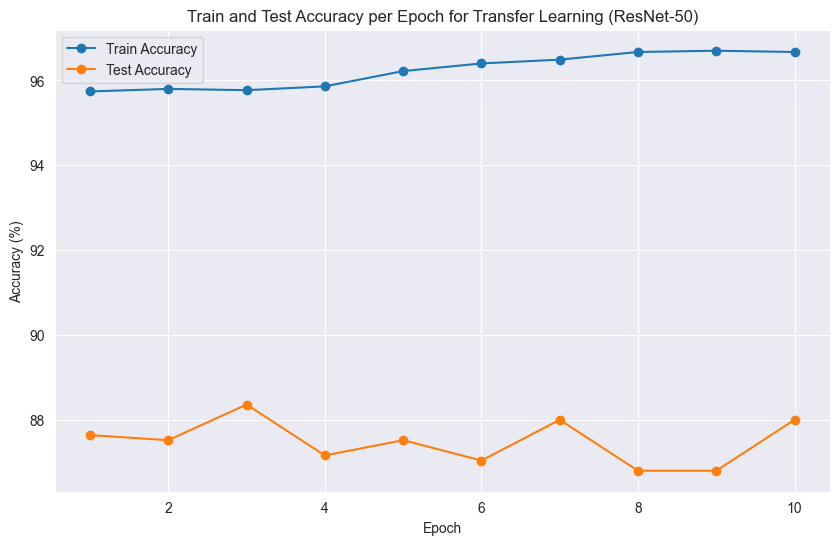

In [15]:
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    model.to(device)
    train_accuracies = []  # Store training accuracy for each epoch
    test_accuracies = []   # Store test accuracy for each epoch
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        # Calculate and store training accuracy
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        
        # Calculate test accuracy
        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        
        # Calculate and store test accuracy
        test_accuracy = 100 * correct_test / total_test
        test_accuracies.append(test_accuracy)
        
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")
    
    return train_accuracies, test_accuracies

# Initialize and train the model while tracking accuracies
print("\nTraining Transfer Learning Model (ResNet-50):")
train_accuracies, test_accuracies = train_and_evaluate(model_resnet, train_loader, test_loader, criterion, optimizer, epochs=10)

# Plotting train and test accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), train_accuracies, marker='o', label='Train Accuracy')
plt.plot(range(1, 11), test_accuracies, marker='o', label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train and Test Accuracy per Epoch for Transfer Learning (ResNet-50)")
plt.legend()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import time


# Data loaders
batch_size = 64


# Load ResNet-50 model with pretrained weights and modify the final layer
CNN = models.resnet50(weights="IMAGENET1K_V2")  # Use pre-trained weights
CNN.fc = nn.Linear(CNN.fc.in_features, 3)  # Adjust final layer for 3 classes
CNN = CNN.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(CNN.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  # Reduce LR every 7 epochs

# Training parameters
num_epochs = 10
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

# Training and evaluation function
def train_and_evaluate(model, criterion, optimizer, scheduler, num_epochs=10):
    start_time = time.time()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        train_losses.append(train_loss / total)
        train_accuracies.append(correct / total)

        # Testing phase
        model.eval()
        test_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        
        test_losses.append(test_loss / total)
        test_accuracies.append(correct / total)

        scheduler.step()  # Update learning rate

        elapsed_time = time.time() - start_time
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, '
              f'Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}, '
              f'Time: {elapsed_time:.2f}s')

# Train and evaluate
train_and_evaluate(CNN, criterion, optimizer, scheduler, num_epochs)

# Plotting
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, test_losses, label='Testing Loss', marker='x')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.grid()
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs, test_accuracies, label='Testing Accuracy', marker='x')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


Epoch [1/10], Train Loss: 0.6690, Train Accuracy: 0.7578, Test Loss: 0.2460, Test Accuracy: 0.9148, Time: 226.62s
Epoch [2/10], Train Loss: 0.1371, Train Accuracy: 0.9643, Test Loss: 0.1982, Test Accuracy: 0.9232, Time: 451.37s
Epoch [3/10], Train Loss: 0.0499, Train Accuracy: 0.9883, Test Loss: 0.2016, Test Accuracy: 0.9304, Time: 673.67s
Epoch [4/10], Train Loss: 0.0209, Train Accuracy: 0.9958, Test Loss: 0.1930, Test Accuracy: 0.9292, Time: 904.64s
